In [1]:
from os.path import join, abspath, expanduser
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [92]:
def correct_utm_to_wgs84(df):
    df_wgs84 = gpd.GeoDataFrame()
    for zone in df['utm_zone'].unique():
        sub = df[df.utm_zone == zone]
        epsg = 26900 + zone
        sub = sub.set_crs(epsg = epsg, allow_override=True).to_crs(epsg = 4326)
        df_wgs84 = df_wgs84.append(sub)
    df_wgs84 = df_wgs84.set_geometry('geom', crs = 4326)
    return df_wgs84

## Database section

In [2]:
#database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas

# Import the connection function from the snowexsql library
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [3]:
# Find all the snow pits done on these days 
qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date, SiteData.id, SiteData.aspect, SiteData.site_name, SiteData.total_depth, SiteData.tree_canopy)

# Return a geopandas df
df_range = query_to_geopandas(qry, engine)
df_db = df_range.sort_values('date')
df_db

,geom,site_id,date,id,aspect,site_name,total_depth,tree_canopy
357,POINT (424563.096 4417714.719),JPL 2,2019-10-24,358,NaN,Fraser Experimental Forest,NaN,No Trees
336,POINT (424541.156 4417657.215),JPL 1,2019-10-24,337,NaN,Fraser Experimental Forest,NaN,No Trees
358,POINT (424562.208 4417711.397),JPL 2,2019-10-29,359,NaN,Fraser Experimental Forest,NaN,No Trees
337,POINT (424542.810 4417651.648),JPL 1,2019-10-29,338,NaN,Fraser Experimental Forest,NaN,No Trees
338,POINT (424540.213 4417648.344),JPL 1,2019-11-24,339,NaN,Fraser Experimental Forest,NaN,No Trees
...,...,...,...,...,...,...,...,...
525,POINT (453356.066 4431402.104),Forest Flat,2020-05-13,526,NaN,Niwot Ridge,NaN,Open (20-70%)
551,POINT (452490.101 4432369.805),Forest South,2020-05-13,552,180.0,Niwot Ridge,NaN,Closed (>70%)
565,POINT (452914.349 4431857.692),Open Flat,2020-05-13,566,NaN,Niwot Ridge,NaN,No Trees
548,POINT (452496.108 4432375.317),Forest South,2020-05-13,549,180.0,Niwot Ridge,NaN,Open (20-70%)


In [9]:
# Find all the snow pits done on these days 
qry = session.query(PointData.site_name, PointData.date, PointData.geom, PointData.time, PointData.units, PointData.utm_zone, )
qry = qry.filter(PointData.instrument != 'Mala 800 MHz GPR')
qry = qry.filter(PointData.type == 'depth')
qry = qry.limit(10)
# Return a geopandas df
df_range = query_to_geopandas(qry, engine)

In [8]:
import datetime
# Find all the data that was collected on 2-12-2020
dt = datetime.date(2020, 2, 12)

#--------------- Point Data -----------------------------------
# Grab all Point data instruments from our date
point_instruments = session.query(PointData.instrument).filter(PointData.date == dt).distinct().all()
point_type = session.query(PointData.type).filter(PointData.date == dt).distinct().all()

# Clean up point data (i.e. remove tuple)
point_instruments = [p[0] for p in point_instruments if p[0] is not None]
point_instruments = ", ".join(point_instruments)
point_type = [p[0] for p in point_type]
point_type = ", ".join(point_type)
print('Point data on %s are: %s, with the following list of parameters: %s' %(str(dt), point_instruments, point_type))

#--------------- Layer Data -----------------------------------
# Grab all Layer data instruments from our date
layer_instruments = session.query(LayerData.instrument).filter(LayerData.date == dt).distinct().all()
layer_type = session.query(LayerData.type).filter(LayerData.date == dt).distinct().all()

# Clean up layer data 
layer_instruments = [l[0] for l in layer_instruments if l[0] is not None]
layer_instruments = ", ".join(layer_instruments)
layer_type = [l[0] for l in layer_type]
layer_type = ", ".join(layer_type)
print('\nLayer Data on %s are: %s, with the following list of parameters: %s' %(str(dt), layer_instruments, layer_type))

#--------------- Image Data -----------------------------------
# Grab all Image data instruments from our date
image_instruments = session.query(ImageData.instrument).filter(ImageData.date == dt).distinct().all()
image_type = session.query(ImageData.type).filter(ImageData.date == dt).distinct().all()

# Clean up image data 
image_instruments = [i[0] for i in image_instruments]
image_instruments = ", ".join(image_instruments)
image_type = [i[0] for i in image_type if i[0] is not None]
image_type = ", ".join(image_type)
print('\nImage Data on %s are: %s, with the following list of parameters: %s' %(str(dt), image_instruments, image_type))

Point data on 2020-02-12 are: camera, magnaprobe, pit ruler, with the following list of parameters: depth

Layer Data on 2020-02-12 are: IRIS, IS3-SP-11-01F, snowmicropen, with the following list of parameters: density, equivalent_diameter, force, grain_size, grain_type, hand_hardness, lwc_vol, manual_wetness, permittivity, reflectance, sample_signal, specific_surface_area, temperature

Image Data on 2020-02-12 are: UAVSAR, L-band InSAR, with the following list of parameters: insar amplitude, insar correlation, insar interferogram imaginary, insar interferogram real


In [ ]:
from rio_geom import rio_to_exterior
from datetime import timedelta
import geopandas as gpd
import contextily as ctx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

res = pd.DataFrame()
for i, image_fp in enumerate(image_fps):
    if i == i:
        dic = {}
        loc = image_fp['location']
        dic['loc'] = loc
        if image_fp['flight1'].date().year == 2021 or image_fp['pol'] != 'HH':
            pass
        else:
            geom = rio_to_exterior(image_fp['cor'])
            for i, dt in enumerate(['flight1', 'flight2']):
                dic[f't{i+1}'] = image_fp[dt]
                dt = image_fp[dt].date()
                # Form a date range to query on either side of our chosen day 
                date_range = [dt + i * timedelta(days=1) for i in [-1, 0, 1]]

                # Find all the snow pits done on these days 
                # Find all the snow pits done on these days 
                qry = session.query(PointData.site_name, PointData.date, PointData.geom, PointData.time, PointData.units, PointData.utm_zone, PointData.value)
                qry = qry.filter(PointData.instrument != 'Mala 800 MHz GPR')
                qry = qry.filter(PointData.type == 'depth')

                # qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
                qry = qry.filter(PointData.date.in_(date_range))

                # Return a geopandas df
                df_range = query_to_geopandas(qry, engine)
                print(df_range)
                # print(loc)
                # print(dic['t1'])
                # print(len(df_range))
                if len(df_range)>0:
                    # View snow pits that are +/- 1 day of the first UAVSAR flight date
                    geom = geom.to_crs(df_range.crs)
                    # print(geom)
                    # print(df_range)
                    points_within = gpd.sjoin(df_range, geom, predicate='within')
                    dic[f't{i+1}_pit_num'] = len(points_within)
                else:
                    loc = image_fp['location']
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    print(f'{dt}_{loc} has none')
            res = pd.concat([res, pd.DataFrame.from_dict([dic])])
            f, ax= plt.subplots(figsize = (12,8))
            print('{} to {} at {}'.format(dic['t1'], dic['t2'], loc))
            geom.plot(ax = ax)
            df_range.plot(ax= ax, color = 'red', zorder = 1)
            ctx.add_basemap(ax = ax, crs = geom.crs)
            plt.show()

     bottom_depth        date  depth                            geom  \
0            58.0  2020-02-26   68.0  POINT (570819.105 4842967.364)   
1            48.0  2020-02-26   58.0  POINT (570819.105 4842967.364)   
2            31.0  2020-02-26   41.0  POINT (570819.105 4842967.364)   
3            21.0  2020-02-26   31.0  POINT (570819.105 4842967.364)   
4            12.0  2020-02-26   21.0  POINT (570819.105 4842967.364)   
..            ...         ...    ...                             ...   
507          20.0  2020-02-26   30.0  POINT (449622.590 4434025.484)   
508          29.0  2020-02-26   39.0  POINT (737376.942 4368074.876)   
509          19.0  2020-02-26   29.0  POINT (737376.942 4368074.876)   
510           9.0  2020-02-26   19.0  POINT (737376.942 4368074.876)   
511           0.0  2020-02-26    9.0  POINT (737376.942 4368074.876)   

    instrument     type     id               value          site_name  \
0         None  lwc_vol  22483                None  Boise Rive

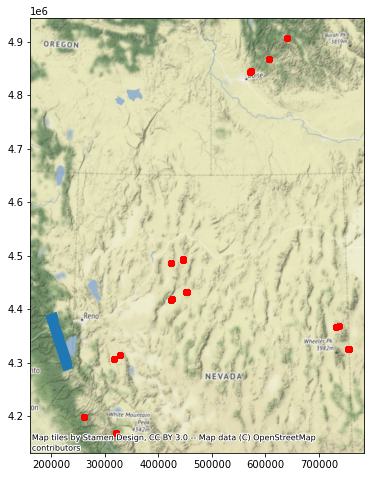

     bottom_depth        date  depth                            geom  \
0           104.0  2020-01-31  114.0  POINT (745340.000 4322754.000)   
1            94.0  2020-02-01  104.0  POINT (745937.000 4322754.000)   
2            84.0  2020-02-01   94.0  POINT (745937.000 4322754.000)   
3            74.0  2020-02-01   84.0  POINT (745937.000 4322754.000)   
4            64.0  2020-02-01   74.0  POINT (745937.000 4322754.000)   
..            ...         ...    ...                             ...   
734          47.0  2020-01-31   57.0  POINT (740652.000 4327445.000)   
735          37.0  2020-01-31   47.0  POINT (740652.000 4327445.000)   
736          27.0  2020-01-31   37.0  POINT (740652.000 4327445.000)   
737          17.0  2020-01-31   27.0  POINT (740652.000 4327445.000)   
738           7.0  2020-01-31   17.0  POINT (740652.000 4327445.000)   

    instrument     type    id value   site_name site_id   easting   northing  \
0         None  lwc_vol  7464   0.0  Grand Mesa    8S28

KeyboardInterrupt: 

In [13]:
from rio_geom import rio_to_exterior
from datetime import timedelta
import geopandas as gpd
import contextily as ctx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

res = pd.DataFrame()
for i, image_fp in enumerate(image_fps):
    if i == i:
        dic = {}
        loc = image_fp['location']
        dic['loc'] = loc
        if image_fp['flight1'].date().year == 2021 or image_fp['pol'] != 'HH':
            pass
        else:
            geom = rio_to_exterior(image_fp['cor'])
            for i, dt in enumerate(['flight1', 'flight2']):
                dic[f't{i+1}'] = image_fp[dt]
                dt = image_fp[dt].date()
                # Form a date range to query on either side of our chosen day 
                date_range = [dt + i * timedelta(days=1) for i in [-1, 0, 1]]

                # Find all the snow pits done on these days 
                qry = session.query(LayerData.bottom_depth, LayerData.date, LayerData.depth, LayerData.geom, LayerData.instrument, LayerData.type, LayerData.id, LayerData.value, LayerData.site_name, LayerData.site_id, LayerData.easting, LayerData.northing, LayerData.utm_zone)
                qry = qry.filter(LayerData.type == 'lwc_vol')
                # qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
                qry = qry.filter(LayerData.date.in_(date_range))

                # Return a geopandas df
                df_range = query_to_geopandas(qry, engine)
                print(df_range)
                # print(loc)
                # print(dic['t1'])
                # print(len(df_range))
                if len(df_range)>0:
                    # View snow pits that are +/- 1 day of the first UAVSAR flight date
                    geom = geom.to_crs(df_range.crs)
                    # print(geom)
                    # print(df_range)
                    points_within = gpd.sjoin(df_range, geom, predicate='within')
                    dic[f't{i+1}_pit_num'] = len(points_within)
                else:
                    loc = image_fp['location']
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    print(f'{dt}_{loc} has none')
            res = pd.concat([res, pd.DataFrame.from_dict([dic])])
            f, ax= plt.subplots(figsize = (12,8))
            print('{} to {} at {}'.format(dic['t1'], dic['t2'], loc))
            geom.plot(ax = ax)
            df_range.plot(ax= ax, color = 'red', zorder = 1)
            print('{} vs {}'.format(geom.crs, df_range.crs))
            ctx.add_basemap(ax = ax, crs = df_range.crs)
            plt.show()

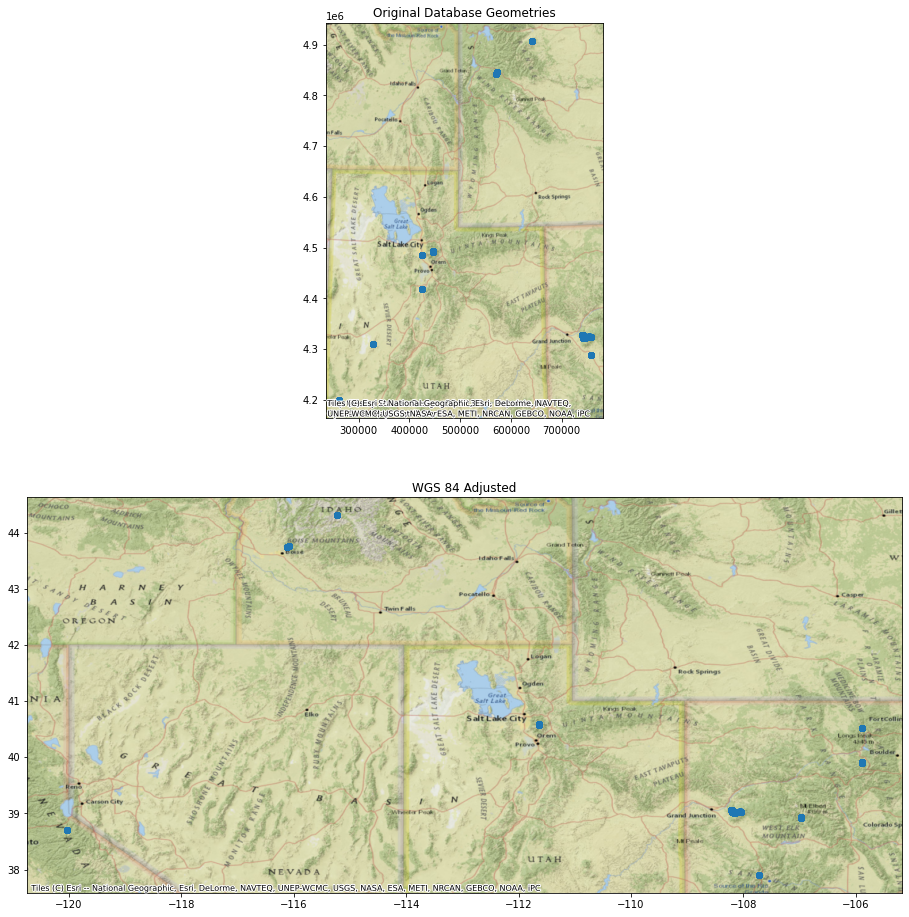

In [90]:
f, axes = plt.subplots(2, figsize = (24,16))
df_wgs84 = gpd.GeoDataFrame()
for zone in df_range['utm_zone'].unique():
    sub = df_range[df_range.utm_zone == zone]
    epsg = 26900 + zone
    sub = sub.set_crs(epsg = epsg, allow_override=True).to_crs(epsg = 4326)
    df_wgs84 = df_wgs84.append(sub)
df_wgs84 = df_wgs84.set_geometry('geom', crs = 4326)
for i, ax in enumerate(axes):
    if i == 0:
        df_range.plot(ax = ax)
        ctx.add_basemap(ax = ax, crs = df_range.crs)
        ctx.add_basemap(ax = ax, crs = df_range.crs, source = ctx.providers.Esri.NatGeoWorldMap)
        ax.set_title('Original Database Geometries')
    else:
        df_wgs84.plot(ax = ax)
        # ctx.add_basemap(ax = ax, crs = df_wgs84.crs)
        ctx.add_basemap(ax = ax, crs = df_wgs84.crs, source = ctx.providers.Esri.NatGeoWorldMap)
        ax.set_title('WGS 84 Adjusted')

plt.show()

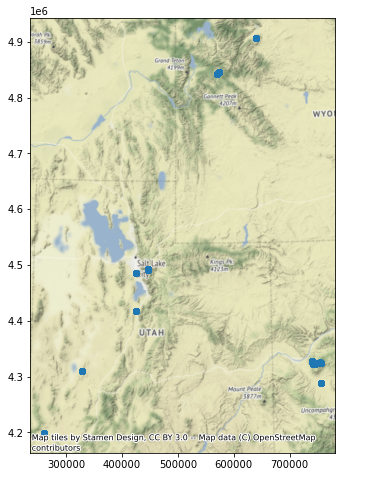

In [44]:
f, ax= plt.subplots(figsize = (12,8))
df_range.plot(ax = ax)
ctx.add_basemap(ax = ax, crs = df_range.crs)
plt.show()

EPSG:4326 vs epsg:26911


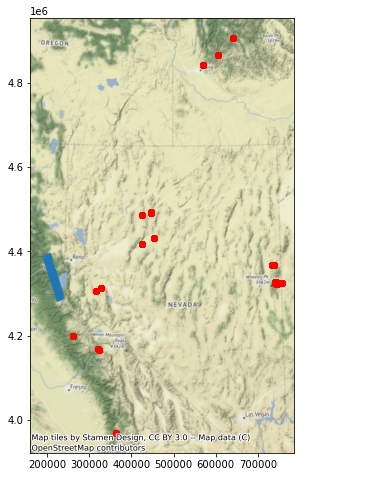

In [11]:
f, ax= plt.subplots(figsize = (12,8))
geom.to_crs(df_range.crs).plot(ax = ax)
df_range.plot(ax= ax, color = 'red', zorder = 1)
print('{} vs {}'.format(geom.crs, df_range.crs))
ctx.add_basemap(ax = ax, crs = df_range.crs)
plt.show()

## CSV part

In [15]:
data_dir = expanduser('~/scratch/data/uavsar/snowpits')
df = pd.read_csv(join(data_dir, 'SNEX20_TS_SP_Summary_SWE_v01.csv'))
df.sort_values('Date/Local Standard Time')